# Input Visuals (Perception Stream)
Visualize tool pose + hand joints over time.

In [2]:
from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure repo root is on sys.path so `import analysis...` works
cwd = Path.cwd()
candidates = [cwd, cwd.parent, cwd.parent.parent]
ROOT = next((p for p in candidates if (p / "analysis").exists()), cwd)
sys.path.insert(0, str(ROOT))

from analysis.src.analysis_pipeline import load_frames

In [3]:
# Point this to your real perception output file when ready
input_path = ROOT / "analysis" / "data" / "samples" / "synth_run_0001" / "frames.json"
frames = load_frames(str(input_path))

len(frames), frames[0].t, frames[-1].t


(301, 0.0, 10.0)

Convert to a tidy DataFrame

In [4]:
rows = []
for fr in frames:
    p = fr.tool.pose.p()
    q = fr.tool.pose.q()
    rows.append({
        "t": fr.t,
        "tool_id": fr.tool.tool_id,
        "tool_type": fr.tool.tool_type,
        "x": float(p[0]), "y": float(p[1]), "z": float(p[2]),
        "qw": float(q[0]), "qx": float(q[1]), "qy": float(q[2]), "qz": float(q[3]),
        "tool_conf": float(fr.tool.confidence),
        "has_left": "left" in fr.hands,
        "has_right": "right" in fr.hands,
        "left_conf": float(fr.hands["left"].confidence) if "left" in fr.hands else np.nan,
        "right_conf": float(fr.hands["right"].confidence) if "right" in fr.hands else np.nan,
    })

df = pd.DataFrame(rows).sort_values("t").reset_index(drop=True)
df.head()


,t,tool_id,tool_type,x,y,z,qw,qx,qy,qz,tool_conf,has_left,has_right,left_conf,right_conf
0,0.000000,tool0,scalpel_like,0.005072,-0.001398,0.500098,0.999688,0.0,0.0,0.024997,0.98,True,True,0.95,0.95
1,0.033333,tool0,scalpel_like,0.000463,-0.001161,0.506087,0.999688,0.0,0.0,0.024997,0.98,True,True,0.95,0.95
2,0.066667,tool0,scalpel_like,0.001704,-0.002259,0.494875,0.999688,0.0,0.0,0.024997,0.98,True,True,0.95,0.95
3,0.100000,tool0,scalpel_like,0.005099,-0.001150,0.497330,0.999688,0.0,0.0,0.024997,0.98,True,True,0.95,0.95
4,0.133333,tool0,scalpel_like,-0.000588,-0.001772,0.499101,0.999688,0.0,0.0,0.024997,0.98,True,True,0.95,0.95


Compute tool speed (for visualization)

In [5]:
t = df["t"].to_numpy()
p = df[["x","y","z"]].to_numpy()

dt = np.diff(t)
dp = np.diff(p, axis=0)
speed = np.zeros_like(t, dtype=float)
safe_dt = np.where(dt <= 1e-9, np.nan, dt)
inst = np.linalg.norm(dp, axis=1) / safe_dt
inst = np.where(np.isfinite(inst), inst, 0.0)
speed[1:] = inst

df["speed"] = speed
df[["t","speed"]].head()


,t,speed
0,0.000000,0.000000
1,0.033333,0.226813
2,0.066667,0.340018
3,0.100000,0.130006
4,0.133333,0.179649


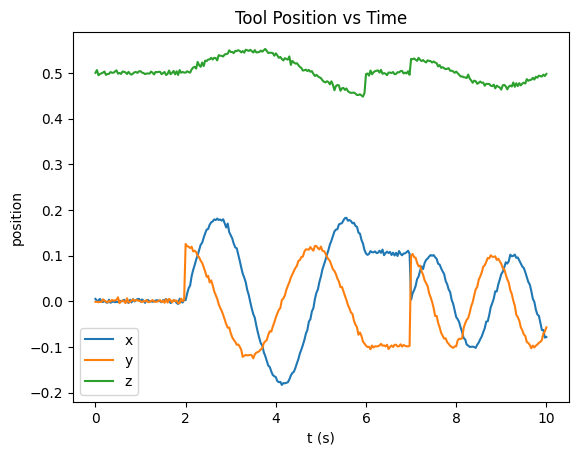

In [6]:
plt.figure()
plt.plot(df["t"], df["x"], label="x")
plt.plot(df["t"], df["y"], label="y")
plt.plot(df["t"], df["z"], label="z")
plt.xlabel("t (s)")
plt.ylabel("position")
plt.title("Tool Position vs Time")
plt.legend()
plt.show()


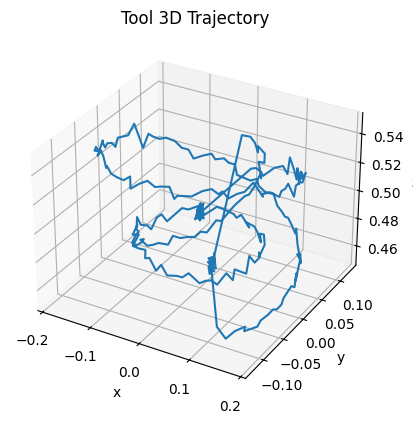

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(df["x"], df["y"], df["z"])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Tool 3D Trajectory")
plt.show()


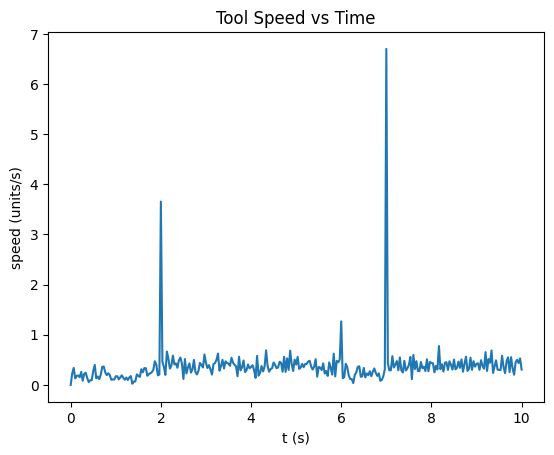

In [8]:
plt.figure()
plt.plot(df["t"], df["speed"])
plt.xlabel("t (s)")
plt.ylabel("speed (units/s)")
plt.title("Tool Speed vs Time")
plt.show()


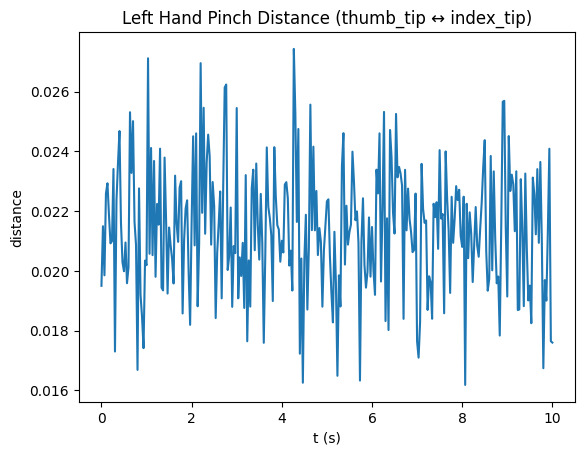

In [9]:
def get_joint(fr, side: str, name: str):
    if side not in fr.hands:
        return None
    j = fr.hands[side].joint(name)
    return None if j is None else j

pinch = []
for fr in frames:
    a = get_joint(fr, "left", "thumb_tip")
    b = get_joint(fr, "left", "index_tip")
    if a is None or b is None:
        pinch.append(np.nan)
    else:
        pinch.append(float(np.linalg.norm(a - b)))

df["left_pinch_dist"] = pinch

plt.figure()
plt.plot(df["t"], df["left_pinch_dist"])
plt.xlabel("t (s)")
plt.ylabel("distance")
plt.title("Left Hand Pinch Distance (thumb_tip ↔ index_tip)")
plt.show()
